# Operations on digital images with Python

Digital images are essentially arrays of numbers. For example an average JPG file you get out of a digital camera is made of three rectangular 2D arrays: one for the red channel, one for the green and one for the blue. Each of these channels is made of numbers between 0 and 255 (it's 8-bit color encoding), which means that we can have up to 16.7 million (16777216 to be exact) colors. As it's all numbers, we can do some analysis and processing using numpy, pandas and matplotlib. Lets load the tools first:


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Let's generate a simple RGB noise test image to begin with:


In [ ]:
def noise_gen(h_res, v_res):
    return np.random.randint(0,256, size = (v_res, h_res, 3), dtype = ('uint8'))

In [ ]:
img = noise_gen(640,480)

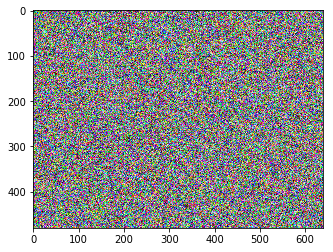

In [374]:
plt.imshow(img)


Let's see what the three color channels look like:


In [ ]:
def channel_splitter(image):
    '''fast numpy-based version, takes an image imported as numpy array and returns a graph 
    with three channels histograms'''
    
    xaxis = np.arange(256)
    fig, ax = plt.subplots()
    for number, color in enumerate(['red', 'green', 'blue']): 
    
        # creates pairs of channel numbers (0-2) and color names
        
        freqcount, _ = np.histogram(image[:,:,number], bins = np.arange(257)) 
        
        # gets the counts for each bin; must be one more bin as np.histogram returns bin edges
        # that is pixels with value 255 are in the bin 255-256
        
        ax.fill_between(xaxis, 0, freqcount, facecolor = color, alpha = 0.3) 
      
        #makes a graph with the correct color for each channel, transparency set to 30%
    
    plt.show()

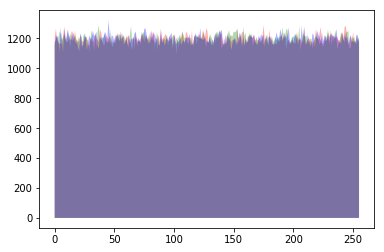

In [240]:
channel_splitter(img)


As the values were chosen using random distribution, the histograms of the three channels look very much alike: all values are represented pretty much equally. 

For further processing we will use a more interesting image, e.g. a landscape. I'm going to use a photo I took a few years ago on a trip to Finland. 


In [ ]:
from skimage import io

In [ ]:
landscape = io.imread('helsinki_a520_IMG_3625.JPG')

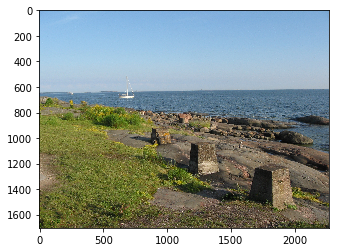

In [247]:
plt.imshow(landscape)


Here's the shape of our image: a three-dimensional array, made of three channels, each of them 1704 x 2272 points.


In [259]:
landscape.shape

(1704, 2272, 3)

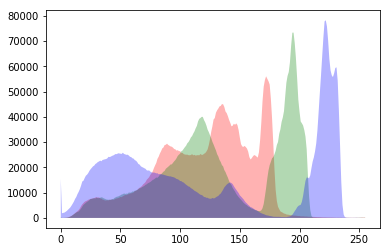

In [248]:
channel_splitter(landscape)

This is definitely more interesting!


Now let's put the three channels of the image into a pandas dataframe. Each color channel gets converted into a one-dimensional array, and then becomes a dataframe column:


In [ ]:
image_df = pd.DataFrame()

for number, color in enumerate(['r','g','b']):
    image_df[color] = np.ravel(landscape[:,:,number])

In [261]:
image_df.head()

,r,g,b
0,125,171,221
1,125,171,221
2,126,172,222
3,125,171,221
4,126,172,222



Now we create equally-sized bins, for further calculations:


In [ ]:
for color in ['r', 'g', 'b']:
    image_df[color+'_bins'] = pd.cut(image_df[color], bins = 16)

In [263]:
image_df.head()

,r,g,b,r_bins,g_bins,b_bins
0,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]"
1,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]"
2,126,172,222,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]"
3,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]"
4,126,172,222,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]"



And now for each channel we calculate the median of all the values in each bin. This way instead of 256 possible values per channel 
we only have 16. 


In [ ]:
def bin_median(group):
    group[color+'_bin_median'] = group[color].median()
    return group

In [265]:
for color in ['r','g','b']:
    image_df = image_df.groupby(color+'_bins').apply(bin_median)

In [266]:
image_df.head()

,r,g,b,r_bins,g_bins,b_bins,r_bin_median,g_bin_median,b_bin_median
0,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0
1,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0
2,126,172,222,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0
3,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0
4,126,172,222,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0



Now let's re-create the image, using these median values. This function takes the three column with previously calculates medians, 
reshapes them to the shape of the original image, and stacks the three 2D arrays together, creating an image with a reduced number of colors:


In [269]:
def make_image(columns):
    channels = []
    for c in columns:
        channel = image_df[c].values
        channel = channel.reshape(landscape.shape[0], landscape.shape[1])
        channels.append(channel)
    image = np.stack(channels, axis = 2)
    image = image.astype('uint8')
    return image
    

In [272]:
landscape_median = make_image(['r_bin_median', 'g_bin_median', 'b_bin_median'])

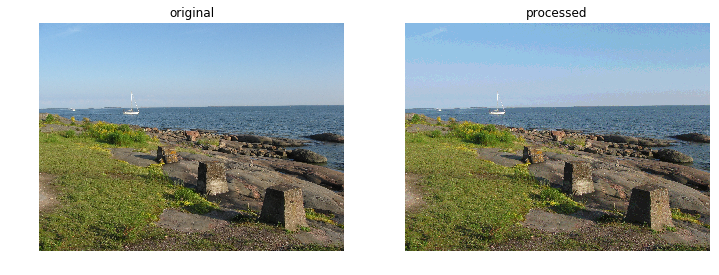

In [276]:
fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(121)
image2 = plt.subplot(122)

_ = image1.imshow(landscape)
_ = image2.imshow(landscape_median)

image1.axis('off')
image1.set_title('original')
image2.axis('off')
image2.set_title('processed')

plt.show()


We can tell that the tonal variation of the image on the right is reduced, it's very noticeable in the sky colors. 

To see what exactly happened we can compare the channels of the original and the processed image. Original image's channels are shown in gray.


In [277]:
def channel_cross_analysis(image1, image2):
    '''takes each color channel from both images and shows two overlaid histograms'''
    xaxis = np.arange(256) # create the x-axis between 0 and 255
    for number, color in enumerate(['red', 'green', 'blue']):
        fig, ax = plt.subplots() # initiate plots    
        freqcount1, _ = np.histogram(image1[:,:,number], bins = np.arange(257))
        freqcount2, _ = np.histogram(image2[:,:,number], bins = np.arange(257))
        ax.fill_between(xaxis, 0, freqcount1, facecolor = 'gray', alpha = 0.4) # gray is the original
        ax.fill_between(xaxis, 0, freqcount2, facecolor = (color), alpha = 0.4) 
        plt.title("{} channel".format(color))
        plt.show()

In [362]:
def channel_cross_analysis(image1, image2):
    '''takes each color channel from both images and shows two overlaid histograms'''
    xaxis = np.arange(256) # create the x-axis between 0 and 255
    fig = plt.figure(figsize = (20,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for number, color in enumerate(['red', 'green', 'blue']): 
    
        ax = fig.add_subplot(1,3,number+1)
        freqcount1, _ = np.histogram(image1[:,:,number], bins = np.arange(257))
        freqcount2, _ = np.histogram(image2[:,:,number], bins = np.arange(257))
        ax.fill_between(xaxis, 0, freqcount1, facecolor = 'gray', alpha = 0.4) # gray is the original
        ax.fill_between(xaxis, 0, freqcount2, facecolor = (color), alpha = 0.4) 
        plt.title("{} channel".format(color))
        
    plt.show()

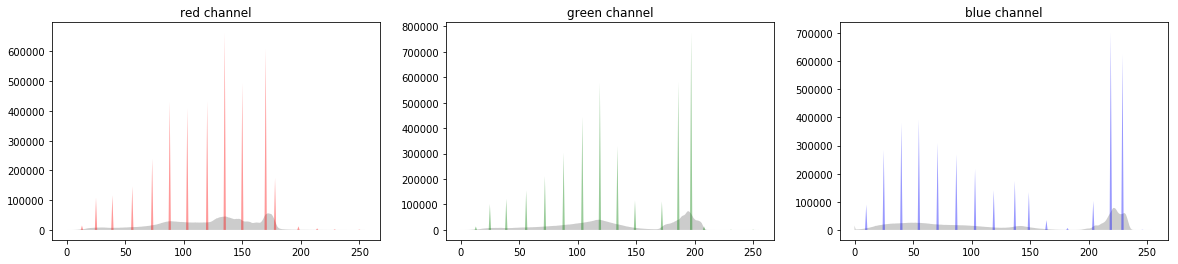

In [363]:
channel_cross_analysis(landscape, landscape_median)


You can see how the smooth curves turned into sharp spikes, as there are much less unique values in each channel. Let's count how many colors were there to start with, and how many are left after this reduction. In order to do that we can create tuples of red, green and blue values in the dataframe, and then count them.  


In [279]:
def tupler(row):
    return (row['r'],row['g'], row['b'])

In [280]:
image_df['orig_color'] = image_df.apply(tupler, axis = 1)

In [282]:
def tupler_m(row):
    return (row['r_bin_median'],row['g_bin_median'], row['b_bin_median'])

In [283]:
image_df['new_color'] = image_df.apply(tupler_m, axis = 1)

In [284]:
image_df.head()

,r,g,b,r_bins,g_bins,b_bins,r_bin_median,g_bin_median,b_bin_median,orig_color,new_color
0,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0,"(125, 171, 221)","(120.0, 172.0, 219.0)"
1,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0,"(125, 171, 221)","(120.0, 172.0, 219.0)"
2,126,172,222,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0,"(126, 172, 222)","(120.0, 172.0, 219.0)"
3,125,171,221,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0,"(125, 171, 221)","(120.0, 172.0, 219.0)"
4,126,172,222,"(111.562, 127.5]","(159.375, 175.312]","(207.188, 223.125]",120.0,172.0,219.0,"(126, 172, 222)","(120.0, 172.0, 219.0)"


In [285]:
image_df['orig_color'].nunique() #number of unique colors in the original image

192957

In [286]:
image_df['new_color'].nunique() #number of unique colors in the processed image

799


That's a huge reduction!


In [287]:
(image_df['new_color'].nunique()/image_df['orig_color'].nunique())*100

0.4140818938934581


To put it short, only 0.4% of the original colors is left! No wonder that we can see the banding on the sky blues. 



Here's a complete function to do this operation on a given image and number of bins:



In [151]:
def image2pd(image, bins):
    df = pd.DataFrame()
    for number, color in enumerate(['r','g','b']):
        df[color] = np.ravel(image[:,:,number])
    for color in ['r', 'g', 'b']:
        df[color+'_bins'] = pd.cut(df[color], bins = bins)
    def bin_median(grp):
        grp[color+'_bin_median'] = grp[color].median()
        return grp
    for color in ['r','g','b']:
        df = df.groupby(color+'_bins').apply(bin_median)
        
    channels = []
    for c in ['r', 'g', 'b']:
        channel = df[c+'_bin_median'].values
        channel = channel.reshape(image.shape[0], image.shape[1])
        channels.append(channel)
    img_median = np.stack(channels, axis = 2)
    img_median = img_median.astype('uint8')
    return img_median
    
    
    


Let's try it on a different image:


In [290]:
alps = io.imread('image_processing/val_veny.jpg')

In [291]:
alps_median = image2pd(alps,16)

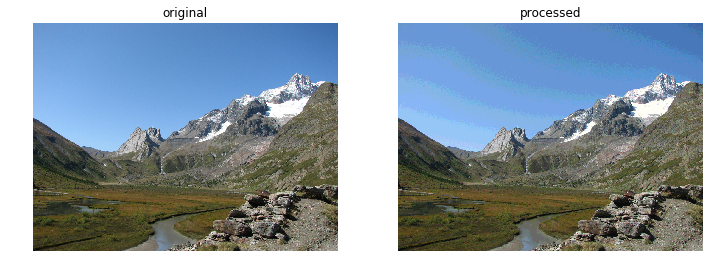

In [292]:

fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(121)
image2 = plt.subplot(122)

_ = image1.imshow(alps)
_ = image2.imshow(alps_median)

image1.axis('off')
image1.set_title('original')
image2.axis('off')
image2.set_title('processed')

plt.show()



Again, clear banding can be observed in the processed image where colors transition smoothly in the original. 



The pd.cut function we use to split these values into bins creates bins of equal width, e.g. in our case it would be (roughly) 0-15, 16-31 and so on. Pandas has another function, pd.qcut, which creates the bins in such way that each of them has the same amount of observations in it. Let's see if it changes anything.


In [296]:
def image2pd_q(image, bins):
    df = pd.DataFrame()
    for number, color in enumerate(['r','g','b']):
        df[color] = np.ravel(image[:,:,number])
    for color in ['r', 'g', 'b']:
        df[color+'_bins'] = pd.qcut(df[color], bins)
    def bin_median(grp):
        grp[color+'_bin_median'] = grp[color].median()
        return grp
    for color in ['r','g','b']:
        df = df.groupby(color+'_bins').apply(bin_median)
        
    channels = []
    for c in ['r', 'g', 'b']:
        channel = df[c+'_bin_median'].values
        channel = channel.reshape(image.shape[0], image.shape[1])
        channels.append(channel)
    img_median = np.stack(channels, axis = 2)
    img_median = img_median.astype('uint8')
    return img_median

In [297]:
alps_median_q = image2pd_q(alps, 16)

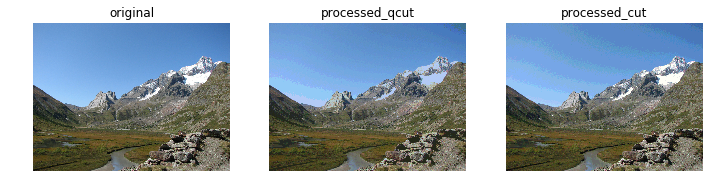

In [302]:
fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(131)
image2 = plt.subplot(132)
image3 = plt.subplot(133)

_ = image1.imshow(alps)
_ = image2.imshow(alps_median_q)
_ = image3.imshow(alps_median)

image1.axis('off')
image1.set_title('original')
image2.axis('off')
image2.set_title('processed_qcut')
image3.axis('off')
image3.set_title('processed_cut')

plt.show()


The trasitions are less abrupt, but something strange is happening with the colors: the whites became blue! Let's have a look at the channels (gray is original image). 

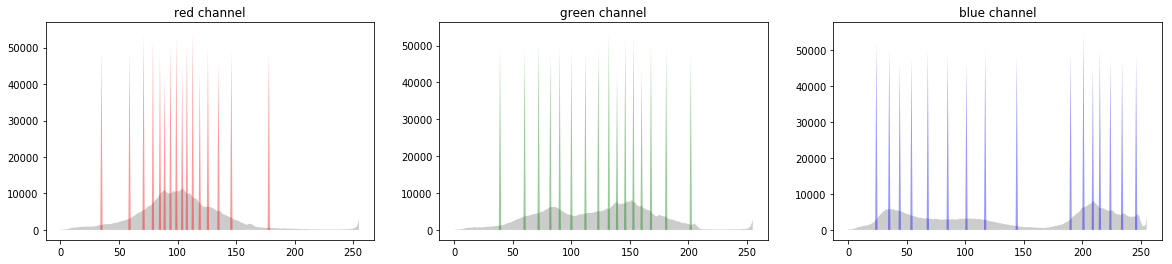

In [364]:
channel_cross_analysis(alps, alps_median_q)


You can see there's a small spike on the far right ot the spectrum: this is the snow in the photo. After the processing with pd.qcut the white disappears: as the bins correspond to the "mainstream", these rare values disappear. In this case, though, it is very visible. Let's have a look at the channels again, this time between the two reduced images:



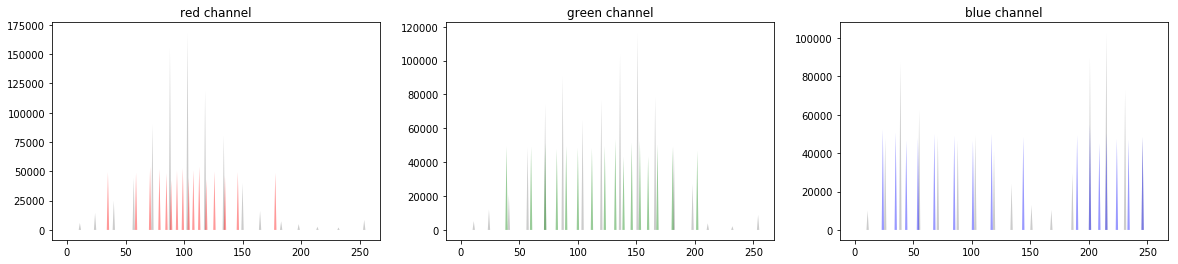

In [365]:
channel_cross_analysis(alps_median, alps_median_q)


You can see those gray spikes (pd.cut processed image) without their corresponding colored spikes: these are the colors that you notice when they disappear, as they are relatively important to the whole image. Let's find out how many unique colors are there in the qcut-processed image.


In [368]:
def color_counter(image):
    df = pd.DataFrame()
    for number, color in enumerate(['r', 'g', 'b']):
        df[color] = np.ravel(image[:,:,number])
    def tupler(row):
        return (row['r'],row['g'], row['b'])
    df['colors'] = df.apply(tupler, axis = 1)
    
    return print("There are {} unique colors in the analyzed image.".format(df['colors'].nunique()))
        

In [369]:
color_counter(alps_median_q)

There are 1207 unique colors in the analyzed image.


In [370]:
color_counter(alps_median)

There are 733 unique colors in the analyzed image.



It comes out that using quantiles instead of equally-spaced bins the color reduction is less effective, and we ran into some problems with colors actually changing a lot. The thing here is, both these approaches are flawed. The colors in our image are made of triplets: r, g, b, therefore processing values independently may lead to some unexpected color shifts. Imagine a neutral gray color: it's channel values are 128, 128, 128. Now because of how the rest of the image is, it may happen that the medians will become 120, 125 and 130: this is not a neutral gray anymore. 
